<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 
</p>    
<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.


**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*

 
    
<p>
La requête SQL suivante a permis de récupérer :

* les données du jeux d'entrainement:     

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id<200000 and PostTypeId=1;``
    

* les données du jeux de test :

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id>=200000 and Id<300000 and PostTypeId=1;``
    
</p>
<p>



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p6_util
import p6_util_plot

# <font color='blus'>1. Paramaters</font>

In [2]:
#-------------------------------------------------------------------------------
# Apply or not stemming process over sentences
#-------------------------------------------------------------------------------
is_stemming=False

## <font color='blus'>2. SOF Tags analysis</font>

In [3]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

In [4]:
df_sof_tags.shape, df_sof_tags.columns

((50000, 2), Index(['TagName', 'Count'], dtype='object'))

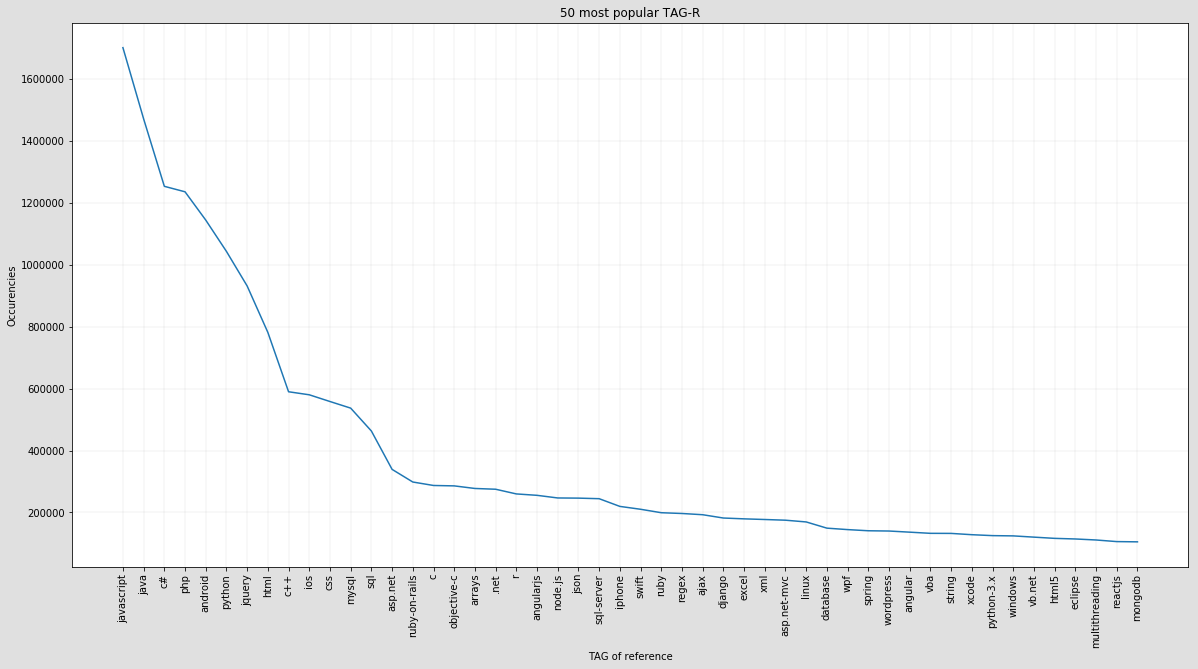

In [5]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular TAG-R"
p6_util_plot.ser_item_occurency_plot(df_sof_tags.TagName,df_sof_tags.Count,item_count\
                                     , title, p_x_title="TAG of reference", p_y_title="Occurencies")

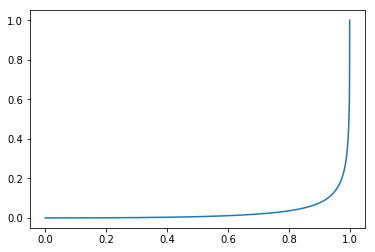

0.9433176218791084

In [6]:
import numpy as np

dep =df_sof_tags.Count.values

import matplotlib.pyplot as plt

lorenz = np.cumsum(np.sort(df_sof_tags.Count)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
plt.show()

# Pour l'indice de GINI
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

---------------------------Count----------------------------
Moyenne: 948.7015
Mediane: 35.0
Modes: 0    1
dtype: int64
Variance: 311074324.89710766
Ecart:17637.299251787605


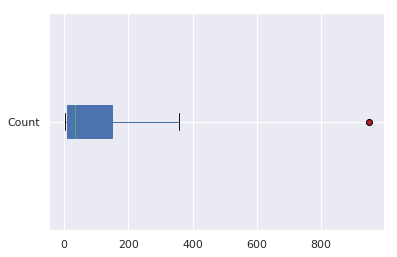

In [7]:
import p5_util_plot
import p3_util_plot
p3_util_plot.df_boxplot_list_display(df_sof_tags, ['Count'], show_outliers=False )


/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


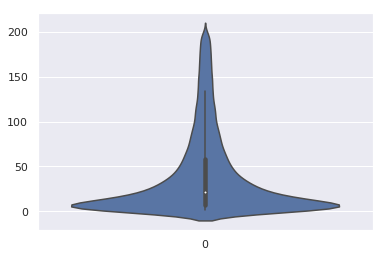

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.violinplot( data=df_sof_tags[df_sof_tags.Count<200].Count)

In [9]:
import scipy
# Chapiro/Wilk test
x = df_sof_tags['Count']

shapiro_results = scipy.stats.shapiro(x[:4000])
print("Shapiro test : Statistics= {} / p-value= {}".format(shapiro_results[0],shapiro_results[1] ))


ks_results = scipy.stats.kstest(x, cdf='norm')
print("Kolmogorov/Smirnov test : Statistics= {} / p-value= {}".format(ks_results[0],ks_results[1] ))


# P-value is read as 0.0 (meaning it is "practically" 0 given the decimal accuracy of the test) then we have strong evidence to not reject the null-hypothesis



Shapiro test : Statistics= 0.01359790563583374 / p-value= 0.0
Kolmogorov/Smirnov test : Statistics= 0.9386498680518208 / p-value= 0.0


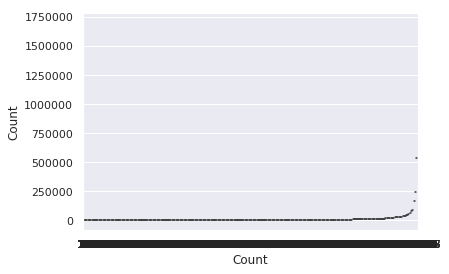

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(y=x, x='Count', 
                       data=df_sof_tags, 
                       width=0.8,
                       inner='quartile',
                       palette="colorblind")

# <font color='blus'>3. POST analysis</font>

In [11]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

list_to_keep = df_sof_tags.TagName.tolist()
df_sof_tags.shape, df_sof_tags.columns

((50000, 2), Index(['TagName', 'Count'], dtype='object'))

In [12]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)


In [13]:
print(df_sof_train.columns)

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')


## <font color='blus'>3.0. Train data-set standardization exploration</font>

**Merge Body and Title columns**

``Title`` elements are regarded as synthetisis of ``Body`` elements.

Merging ``Title`` with ``Body`` enreach ``Body`` contents with more relevant informations.

In [14]:
df_sof_train['BodyTitle']=df_sof_train['Body']+df_sof_train['Title']

**Dataset processing**

Expressions between markers ``code`` and ``/code`` are all removed.

Such expressions are computer language specifics, different as english language. It is considered as having  no semantic value for english language.

In [15]:
df_sof_train.columns

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags', 'BodyTitle'], dtype='object')

**Each one of the POST from corpus is tokenized**

In [17]:
list_tokeep = df_sof_tags.TagName.tolist()
list_to_keep = list_tokeep

In [18]:
'd3.js' in list_tokeep

True

In [19]:
ipost=10
list_tokeep.append("worked")
print("worked" in list_tokeep)
post= df_sof_train.Body[ipost]
print(post)

True
<p>I'm having issues getting the C sockets API to work properly in C++ on <code>z/OS</code>.</p>

<p>Although I am including <code>sys/socket.h</code>, I still get compile time errors telling me that <code>AF_INET</code> is not defined.</p>

<p>Am I missing something obvious, or is this related to the fact that being on <code>z/OS</code> makes my problems much more complicated?</p>

<hr>

<p><strong>Update</strong>: Upon further investigation, I discovered that there is an <code>#ifdef</code> that I'm hitting. Apparently <code>z/OS</code> isn't happy unless I define which "type" of sockets I'm using with:</p>

<pre><code>#define _OE_SOCKETS
</code></pre>

<p>Now, I personally have no idea what this <code>_OE_SOCKETS</code> is actually for, so if any <code>z/OS</code> sockets programmers are out there (all 3 of you), perhaps you could give me a rundown of how this all works?</p>

<hr>

<p>Test App</p>

<pre><code>#include &lt;sys/socket.h&gt;

int main()
{
    return AF_INET;
}
</c

In [20]:
'd3.js' in list_to_keep

True

In [21]:
import p6_util
ser = p6_util.p6_str_standardization(post, list_to_keep=list_to_keep\
                                     ,is_lem=False, verbose=True)
ser[0]
list_post=ser[0].split(" ")
print(list_post)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Removing stopwords...
['issues', 'c', 'sockets', 'api', 'c++', 'which', 'file']


In [22]:
str_title_token=df_sof_train.Title[ipost].lower()
print(str_title_token)
ser = p6_util.p6_str_standardization(str_title_token, list_to_keep=list_to_keep\
                                     ,is_lem=False, verbose=True)
ser[0]
list_post=ser[0].split(" ")
print(list_post)
list_title_token = str_title_token.split(" ")


how to use the c socket api in c++ on z/os

Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Removing stopwords...
['c', 'socket', 'api', 'c++', 'z/os']


In [23]:
import p6_util
list_tag_a = df_sof_train.Tags[ipost].lower()
list_tag_a=p6_util.clean_marker_text(list_tag_a, leading_marker='<', trailing_marker='>')
print(list_tag_a)

['c++', 'c', 'sockets', 'mainframe', 'zos']


In [24]:
list_tag_r = df_sof_tags.TagName.tolist()
set(ser[0]).intersection(list_tag_a+list_title_token)
list_post=list(set(list_post+list_title_token))
print("List from POST= "+str(list_post))
print("List from LIST_TAG_A= "+str(list_tag_a))
print()
print("POST intersection LIST_TAG_A : "+str(set(list_post).intersection(list_tag_a)))
print("POST intersection LIST_TAG_R : "+str(set(list_post).intersection(list_tag_r)))
print("LIST_TAG_A intersection LIST_TAG_R : "+str(set(list_tag_a).intersection(list_tag_r)))
"m" in list_tokeep

List from POST= ['z/os', 'in', 'c++', 'socket', 'use', 'api', 'the', 'how', 'on', 'c', 'to']
List from LIST_TAG_A= ['c++', 'c', 'sockets', 'mainframe', 'zos']

POST intersection LIST_TAG_A : {'c', 'c++'}
POST intersection LIST_TAG_R : {'c++', 'api', 'c'}
LIST_TAG_A intersection LIST_TAG_R : {'sockets', 'mainframe', 'c++', 'c', 'zos'}


True

**List of text processing allowing to standardize a post**

In [25]:
import p6_util
ser_train = df_sof_train.BodyTitle.sample(10000)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Removing stopwords...


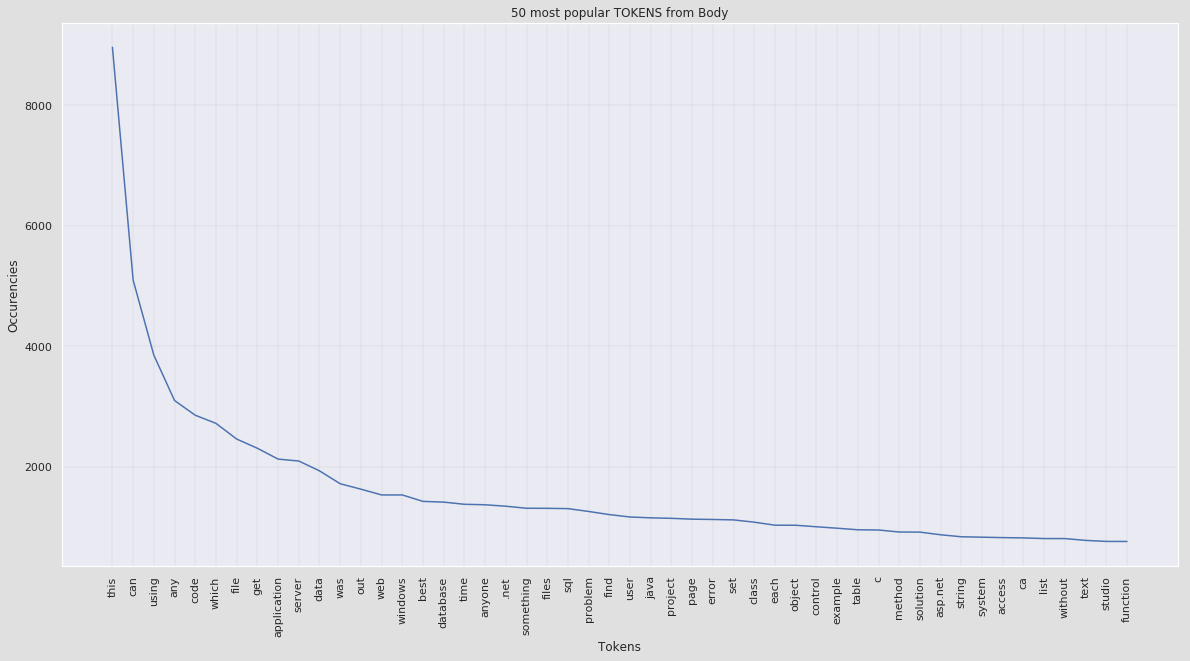

In [26]:
import p6_util

ser_post = p6_util.p6_df_standardization(ser_train, is_stemming=False, is_lem=False\
    , is_stopword=True, verbose=True, list_to_keep=list_to_keep
    , is_sentence_filter=False) 

df_word_count = p6_util.ser_corpus_2_df_word_count(ser_post, token_mode='split')

import p6_util_plot

item_count=50
title = str(item_count)+" most popular TOKENS from Body"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [27]:
print('c#' in list_to_keep)
len(list_to_keep)

True


50001

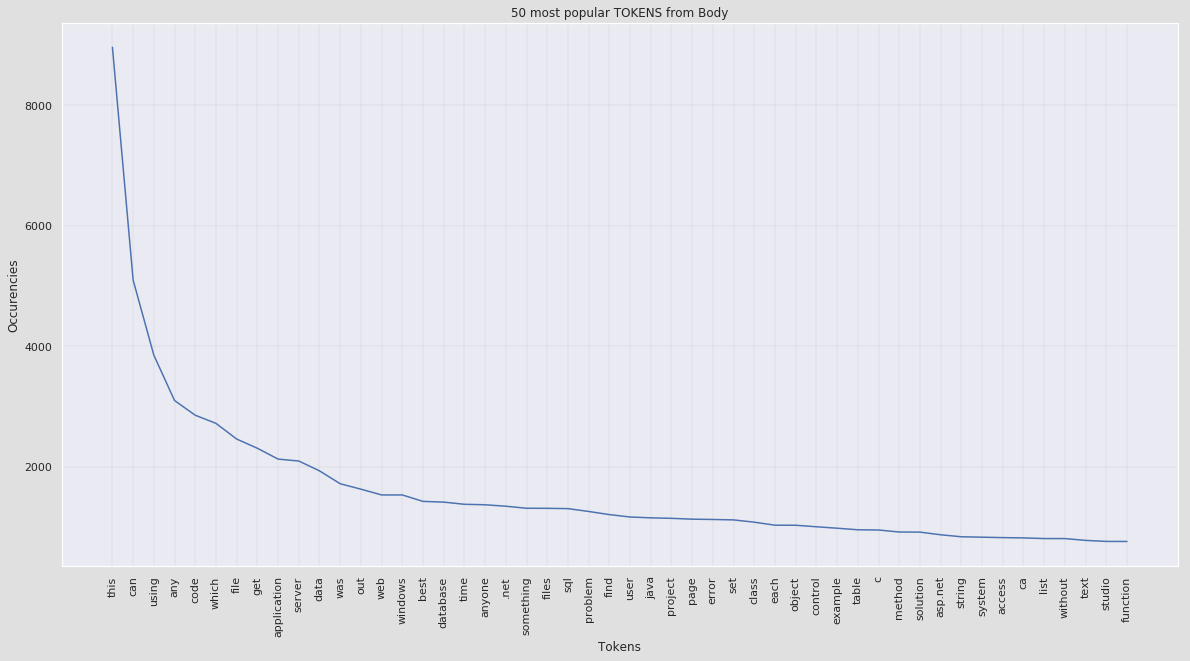

In [28]:
import p6_util
list_ser_post = list()
ser_post = ser_train.copy()
if False:
    for post in ser_train :
        post +=" d3.js c# c++ a b c d i've I'd I'm"
        #print(post)
        ser_post = p6_util.p6_str_standardization(post, verbose=False, is_stopalfanum=False)
        
        
        list_ser_post.append(ser_post)
    ser_post=pd.Series({i:post[0] for i,post in zip(range(0, len(list_ser_post)),list_ser_post)})
else :
    ser_post = ser_post.apply(p6_util.cb_remove_marker,args=('code',))
    ser_post = ser_post.apply(p6_util.cb_clean_lxml)
    ser_post = ser_post.apply(p6_util.cb_remove_verb_from_sentence, args=(list_to_keep,))
    
    #ser_post = ser_post.apply(p6_util.cb_sentence_filter, args=(list_to_keep,))
    ser_post= ser_post.apply(p6_util.cb_remove_stopwords, args=(list_to_keep,))
    #ser_post = p6_util.p6_df_standardization(ser, is_stemming=is_stemming\
    #, is_lem=False, verbose=False, list_to_keep=list_to_keep\
    #, is_sentence_filter=False)
    
    
df_word_count = p6_util.ser_corpus_2_df_word_count(ser_post, token_mode='split')

import p6_util_plot

item_count=50
title = str(item_count)+" most popular TOKENS from Body"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [29]:
df_word_count.iloc[1]

Word     computers
Count           43
Name: 1, dtype: object

In [30]:
list_to_keep = ['c#']

def cb_remove_verb_from_sentence(sentence, list_to_keep=list(), verbose=False) :
    tokenized_sentence = nltk.word_tokenize(sentence.lower())

    if verbose is True :
        print(tokenized_sentence)
        print()

    #Rebuild c# 
    i_offset=0
    tokens=None
    for i, token in enumerate(tokenized_sentence):
        i -= i_offset
        if token == '#' and i > 0:
            left = tokenized_sentence[:i-1]
            joined = [tokenized_sentence[i - 1] + token]
            right = tokenized_sentence[i + 1:]
            tokens = left + joined + right
            i_offset += 1
    
    if tokens is not None:
        tokenized_sentence = tokens
    if verbose is True :
        print(tokenized_sentence)
        print()


    list_tagged = nltk.pos_tag(tokenized_sentence)
    if verbose is False :
        print(list_tagged)
        print()


    list_pos_tag_excluded \
        = ['PRP','VB','VBP','VBN','CD','VBD','JJ','PRP','VBZ','DET','VBG','MD','NN$'\
           ,':',')','(','.','NNP','PDT',"``","''",'CC','POS',',','RB']


    list_token_excluded = ['i','s','m',',','question','this','can','using']
    list_token_filtered \
        = [token for (token, tag) in list_tagged \
        if str(tag) not in list_pos_tag_excluded \
        and token not in list_token_excluded  or token in list_to_keep \
        #or token in list_to_keep 
        ]

    if False :
        for token, tag in list_tagged :
            if tag == ':' :
                print(token,tag,tag in list_pos_tag_excluded,list_pos_tag_excluded)

    if verbose is True :
        print(list_token_filtered)
        print()
    sentence = " ".join(list_token_filtered)
    #sentence = nltk.Text(list_token_filtered)
    if True:
        tokenized_sentence \
                    = nltk.regexp_tokenize(sentence, pattern=r"\s|[\,;]:!?()<>", gaps=True)
        sentence = " ".join(tokenized_sentence)
    else :
        pass
    return sentence

In [35]:
import string
len(list_to_keep)
print(string.punctuation)
string_punct = string.punctuation
list_punct=[string_punct[i] for i in range(0, len(string_punct))]
list_punct
string_punct = " ".join(list_punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [37]:
import nltk

post=string_punct
post=df_word_count.iloc[1][0]
post="don't"
post=" . can I'm I've I'd \ this how to html know m aging : ; @ ` ' ''' `` ' s can I've 4  made d3.js . from C# c# c# and C++ and also C unused is very big that is very great! er@yoo.com <() > ) ? ! "
#post=ser_train.iloc[0]
print('html' in list_to_keep)

print(post)
print()

post = p6_util.cb_remove_marker(post,'code')
print(post)
print()

post = p6_util.cb_clean_lxml(post)
print(post)
print()
post = cb_remove_verb_from_sentence(post, list_to_keep=list_to_keep)
print(post)
print()

#post= p6_util.cb_remove_stopwords(post,list_to_keep)
print()
print("End :"+post)


False
 . can I'm I've I'd \ this how to html know m aging : ; @ ` ' ''' `` ' s can I've 4  made d3.js . from C# c# c# and C++ and also C unused is very big that is very great! er@yoo.com <() > ) ? ! 

 . can i'm i've i'd \ this how to html know m aging : ; @ ` ' ''' `` ' s can i've 4  made d3.js . from c# c# c# and c++ and also c unused is very big that is very great! er@yoo.com <() > ) ? ! 

. can i'm i've i'd \ this how to html know m aging : ; @ ` ' ''' `` ' s can i've 4  made d3.js . from c# c# c# and c++ and also c unused is very big that is very great! er@yoo.com  ) ? ! 

[('.', '.'), ('can', 'MD'), ('i', 'VB'), ("'m", 'VBP'), ('i', 'JJ'), ("'ve", 'VBP'), ('i', 'VBN'), ("'d", 'MD'), ('\\', 'VB'), ('this', 'DT'), ('how', 'WRB'), ('to', 'TO'), ('html', 'VB'), ('know', 'VB'), ('m', 'JJ'), ('aging', 'NN'), (':', ':'), (';', ':'), ('@', 'CC'), ('`', '``'), ("'", "''"), ('``', '``'), ("'", 'POS'), ('``', '``'), ("'", 'POS'), ('s', 'NN'), ('can', 'MD'), ('i', 'VB'), ("'ve", 'VBP'), ('4'

In [38]:
ser = pd.Series({0:ser.iloc[0]})

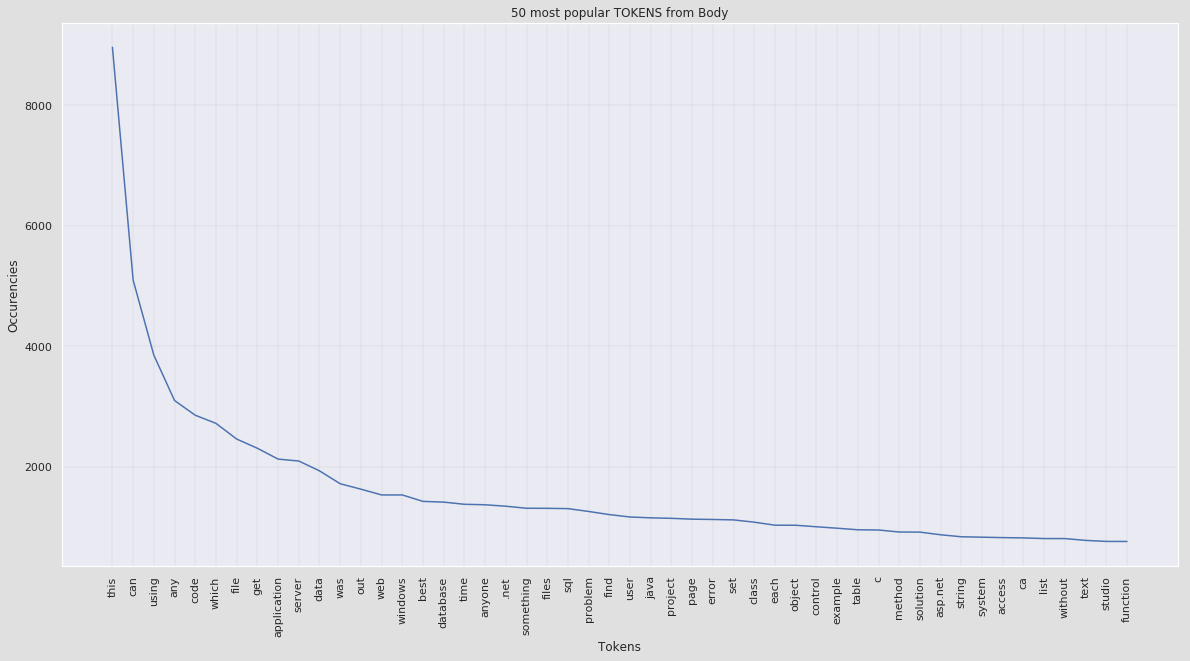

In [39]:
import p6_util

verbose=False
is_sentence_filter=False

if True :
    if verbose is True :
        print("\nCleaning text in-between markers <code></code> markers...")
    ser = ser.apply(p6_util.cb_remove_marker,args=('code',))

    if verbose is True :
        print("\nCleaning LXML markers...")
    ser = ser.apply(p6_util.cb_clean_lxml)

    if is_sentence_filter is True :
        if verbose is True :
            print("\nRemove non alpha-numeric words from sentences...")
        ser = ser.apply(p6_util.cb_sentence_filter, args=(list_to_keep,))
if verbose is True :
    print("\nRemove verbs from sentences...")
ser = ser.apply(p6_util.cb_remove_verb_from_sentence, args=(list_to_keep,))

#"C".isalpha()
df_word_count = p6_util.ser_corpus_2_df_word_count(ser_post, token_mode='split')

import p6_util_plot

item_count=50
title = str(item_count)+" most popular TOKENS from Body"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [40]:
i=1
import p6_util
cleaned_sentance = p6_util.cb_remove_marker(post,'code')
print("1) "+str(cleaned_sentance))
print()

import p6_util
cleaned_sentance = p6_util.cb_clean_lxml(cleaned_sentance)
print("2) "+str(cleaned_sentance))
print()


import p6_util
cleaned_sentance = p6_util.cb_remove_verb_from_sentence(cleaned_sentance, list_to_keep=list_tokeep)
print("3) "+str(cleaned_sentance))
print()


if False :
    cleaned_sentance = p6_util.cb_sentence_filter(cleaned_sentance, list_tokeep)
    print("4) "+str(cleaned_sentance))
    print()

    
cleaned_sentance = p6_util.cb_remove_stopwords(cleaned_sentance, list_to_keep=list_tokeep)
print("5) "+str(cleaned_sentance))
print()


1) how to aging d3.js from # c# c # c++ that er yoo.com

2) how to aging d3.js from # c# c # c++ that er yoo.com

3) how to d3.js from # c# c # c++ that yoo.com

5) d3.js c# c c++ yoo.com



In [41]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import p5_util

lemmatizer=WordNetLemmatizer()
cleaned_sentance = p5_util.cb_lemmatizer(cleaned_sentance, lemmatizer, mode='lower')
print(cleaned_sentance)

d3.js c# c c++ yoo.com


In [42]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk

import p5_util

stemmer=nltk.stem.SnowballStemmer('english')
cleaned_sentance = p5_util.cb_stemmer(cleaned_sentance, stemmer, mode='lower')
print(cleaned_sentance)

d3.js c# c c++ yoo.com


## <font color='blus'>3.1. Train data-set standardization</font>

In [43]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)


**Merge Body and Title columns**

``Title`` elements are regarded as synthetisis of ``Body`` elements.

Merging ``Title`` with ``Body`` enreach ``Body`` contents with more relevant informations.

In [44]:
df_sof_train['BodyTitle']=df_sof_train['Body']+df_sof_train['Title']

### <font color='blus'>3.1.1. Body + Title standardization</font>

**Merge Body and Title columns**

``Title`` elements are regarded as synthetisis of ``Body`` elements.

Merging ``Title`` with ``Body`` enreach ``Body`` contents with more relevant informations.

Series ``ser_sof_train_body`` is converted into a dictionary in order to feed ``compute_frequency_sentence`` function.

In [45]:
'question' in df_sof_tags.TagName.tolist()

False

In [46]:
sample=len(df_sof_train)
print(sample)

24604



Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Removing stopwords...


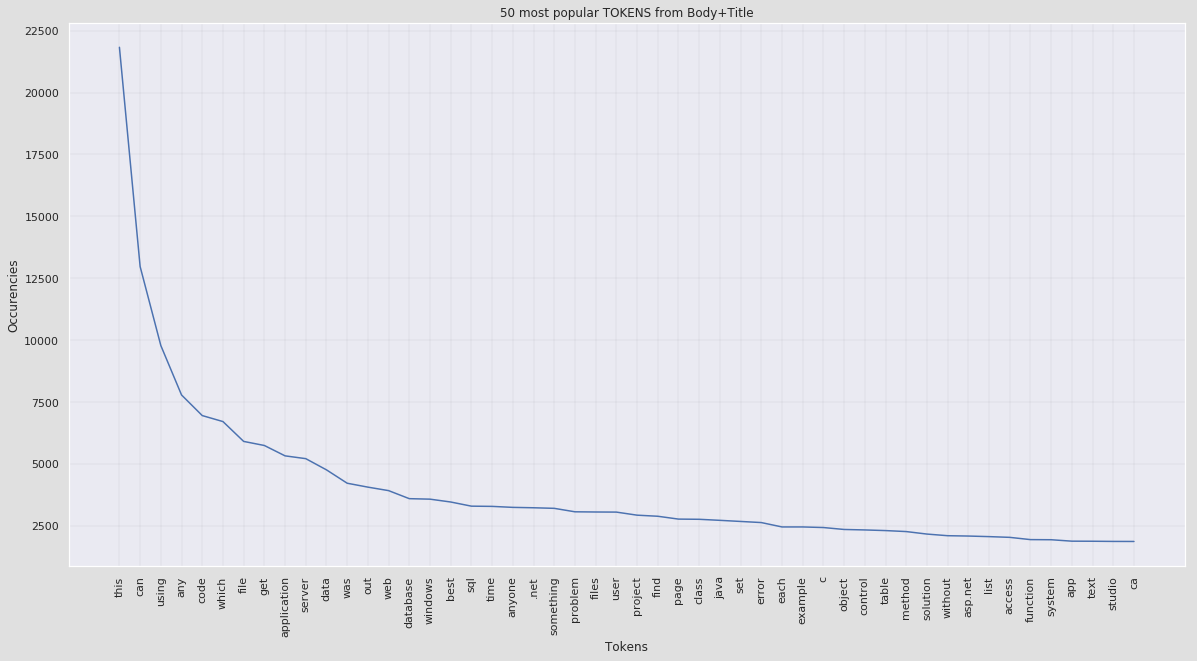

In [47]:
import p5_util
import p6_util
import p6_util_plot

ser_sof_train = p6_util.p6_df_standardization(df_sof_train.BodyTitle.sample(sample), is_lem=False, \
                                               is_sentence_filter=False\
                                              , list_to_keep=df_sof_tags.TagName.tolist())

file_name='./data/ser_sof_train.dump'
p5_util.object_dump(ser_sof_train, file_name)

df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train, token_mode='split')




item_count=50
title = str(item_count)+" most popular TOKENS from Body+Title"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [89]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)


df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train, token_mode='split')

intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG found in Body+Title : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of ref. TAG in Body+Titles = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

p5_util.object_load : fileName= ./data/ser_sof_train.dump
Percent of TAG found in Body+Title : 14.89%
Distribution of ref. TAG in Body+Titles = 13.64%


p5_util.object_load : fileName= ./data/ser_sof_train.dump


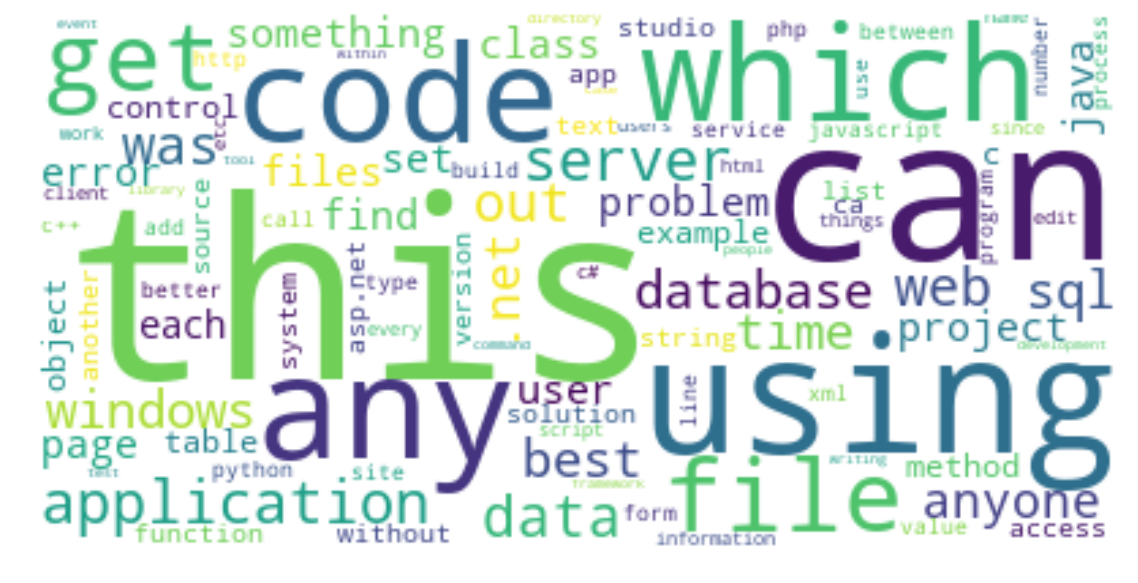

In [92]:
import p6_util_plot
import p6_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)

dict_body_train = ser_sof_train.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='split')
p6_util_plot.display_word_cloud(freq_body_train)

### <font color='blus'>3.1.2. Body standardization</font>


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Removing stopwords...


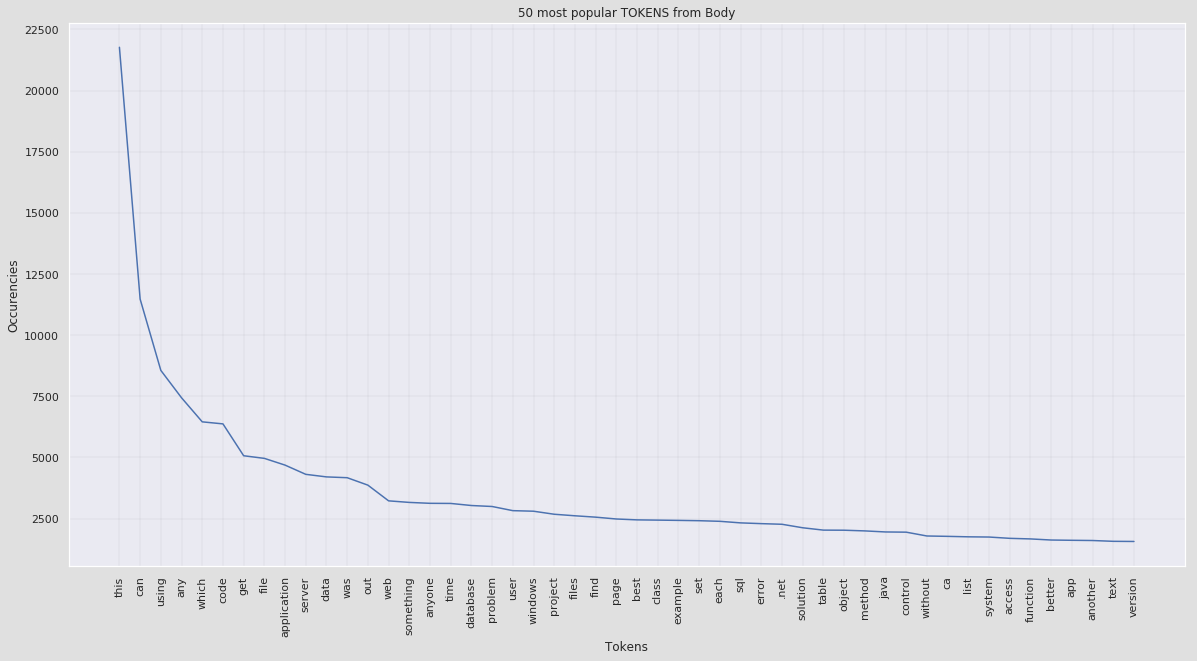

In [48]:
import p5_util
import p6_util
import p6_util_plot

ser_sof_train =  p6_util.p6_df_standardization(df_sof_train.Body.sample(sample), is_lem=False, \
                                               list_to_keep=df_sof_tags.TagName.tolist())

file_name='./data/ser_sof_train_body.dump'
p5_util.object_dump(ser_sof_train, file_name)

df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train, token_mode='split')

item_count=50
title = str(item_count)+" most popular TOKENS from Body"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [90]:
import p5_util
file_name='./data/ser_sof_train_body.dump'
ser_sof_train = p5_util.object_load(file_name)


df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train, token_mode='split')

intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG found in Body : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of ref. TAG in Body = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

p5_util.object_load : fileName= ./data/ser_sof_train_body.dump
Percent of TAG found in Body : 14.32%
Distribution of ref. TAG in Body = 14.60%


p5_util.object_load : fileName= ./data/ser_sof_train_body.dump


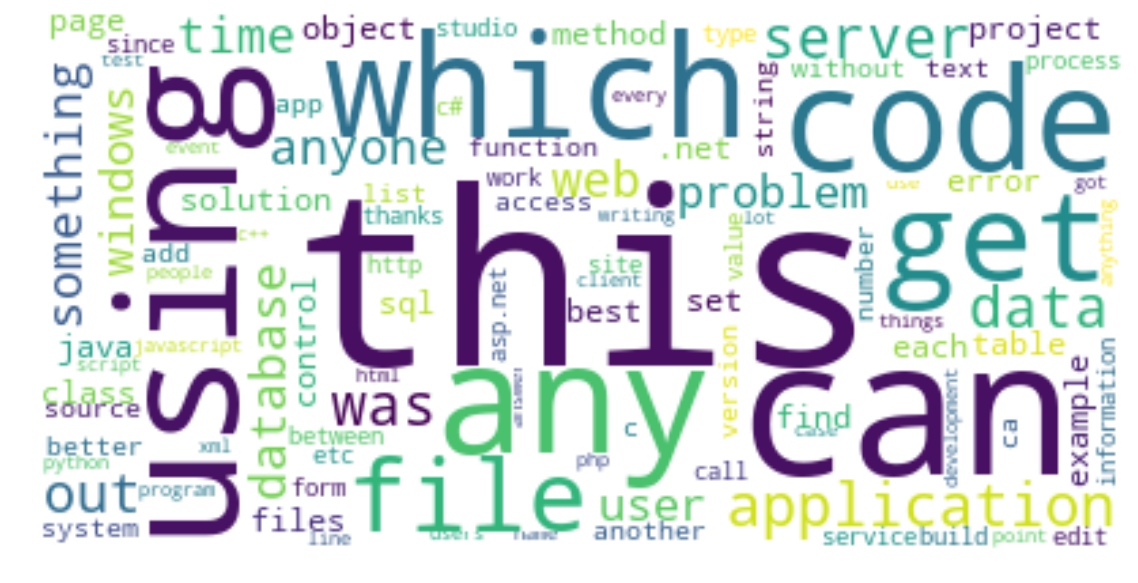

In [91]:
import p6_util_plot
import p6_util
file_name='./data/ser_sof_train_body.dump'
ser_sof_train = p5_util.object_load(file_name)

dict_body_train = ser_sof_train.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='split')
p6_util_plot.display_word_cloud(freq_body_train)

### <font color='blus'>3.1.3. Title standardization</font>


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Removing stopwords...


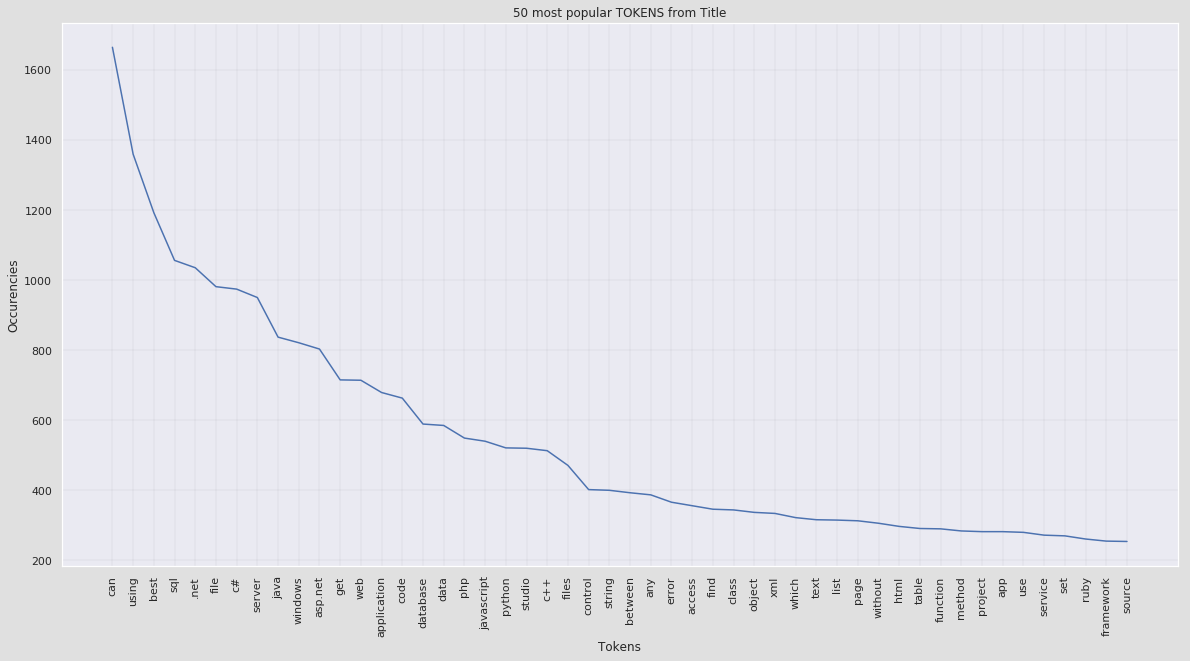

In [49]:
import p5_util
import p6_util
import p6_util_plot


ser_sof_train = p6_util.p6_df_standardization(df_sof_train.Title.sample(sample), is_lem=False, \
                                               list_to_keep=df_sof_tags.TagName.tolist())

file_name='./data/ser_sof_train_title.dump'
p5_util.object_dump(ser_sof_train, file_name)



df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train, token_mode='split')

item_count=50
title = str(item_count)+" most popular TOKENS from Title"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

p5_util.object_load : fileName= ./data/ser_sof_train_title.dump


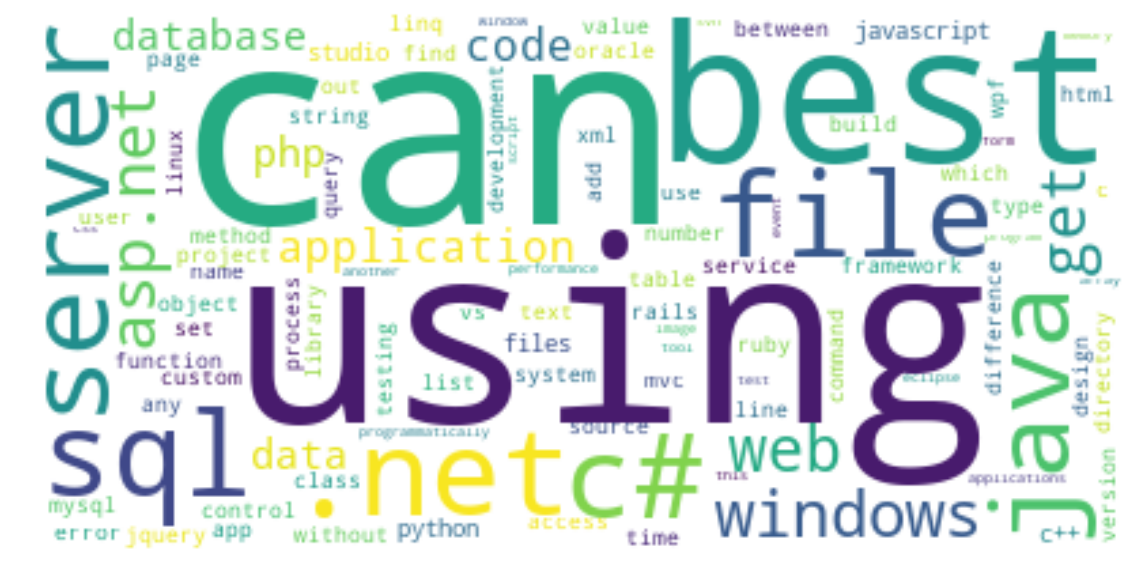

In [84]:
import p6_util_plot
import p6_util
file_name='./data/ser_sof_train_title.dump'
ser_sof_train = p5_util.object_load(file_name)

dict_body_train = ser_sof_train.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='split')
p6_util_plot.display_word_cloud(freq_body_train)

In [85]:
intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG found in titles : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of ref. TAG in titles = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

Percent of TAG found in titles : 9.43%
Distribution of ref. TAG in titles = 42.98%


## <font color='blus'>3.2. Posts analysis</font>

### <font color='blus'>3.2.0. Words from Body occurrencies</font>

**Standardized dataset is loaded from dumped file**

In [51]:
import p5_util
file_name='./data/ser_sof_train_body.dump'
ser_sof_train_body = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/ser_sof_train_body.dump


In [52]:
len(ser_sof_train_body)

24604

In [53]:
import p6_util
df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train_body, token_mode='split')

Series ``ser_sof_train_body`` is converted into a dictionary in order to feed ``compute_frequency_sentence`` function.

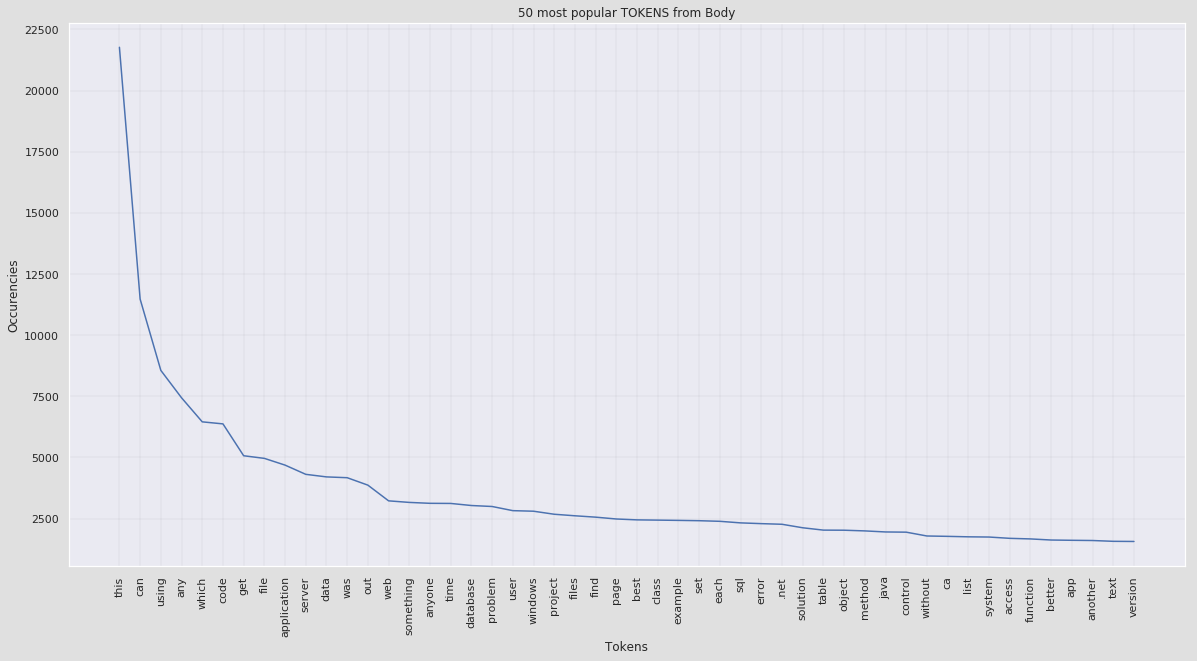

In [54]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular TOKENS from Body"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [55]:
len(df_sof_tags.TagName.tolist())

50000

In [56]:
intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG found in Body : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of ref. TAG in Body = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

Percent of TAG found in Body : 14.32%
Distribution of ref. TAG in Body = 14.60%


### <font color='blus'>3.2.1. Words from Body+Titles occurrencies</font>

**Standardized dataset is loaded from dumped file**

In [57]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/ser_sof_train.dump


In [58]:
ser_sof_train.sample()

18335    post source code example link search string an...
Name: BodyTitle, dtype: object

**Tokens occurencies are computed**

Series ``ser_sof_train`` is converted into a dictionary in order to feed ``compute_frequency_sentence`` function.

In [59]:
import p6_util

df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train, token_mode='nltk')

In [60]:
df_word_count.sample()

,Word,Count
29460,stealth,1


In [61]:
'd3.js' in df_word_count.Word

False

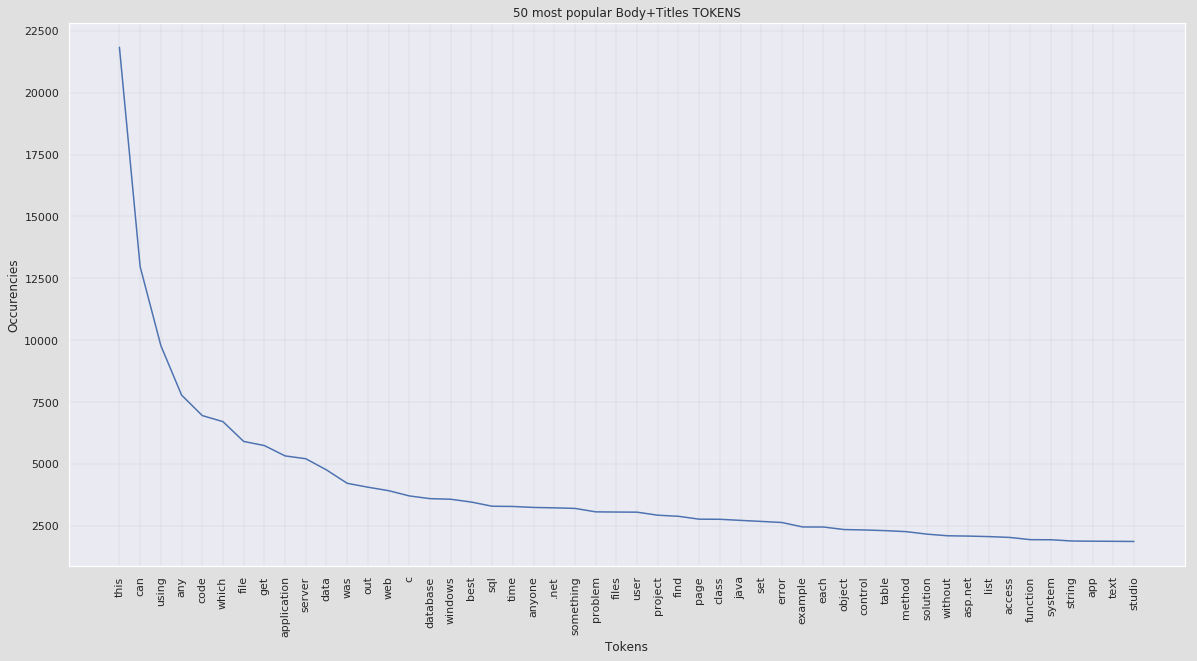

In [62]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular Body+Titles TOKENS"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count\
                                     ,item_count, title, p_reverse=True\
                                     , p_x_title="Tokens", p_y_title="Occurencies")

In [63]:
intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG found in Body+Titles : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of ref. TAG in Body+Titles = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

Percent of TAG found in Body+Titles : 14.89%
Distribution of ref. TAG in Body+Titles = 13.72%


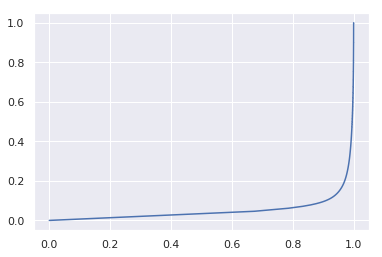

0.9001558862618526

In [64]:
import numpy as np

dep =df_word_count.Count.values

import matplotlib.pyplot as plt

lorenz = np.cumsum(np.sort(df_word_count.Count)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
plt.show()

# Pour l'indice de GINI
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

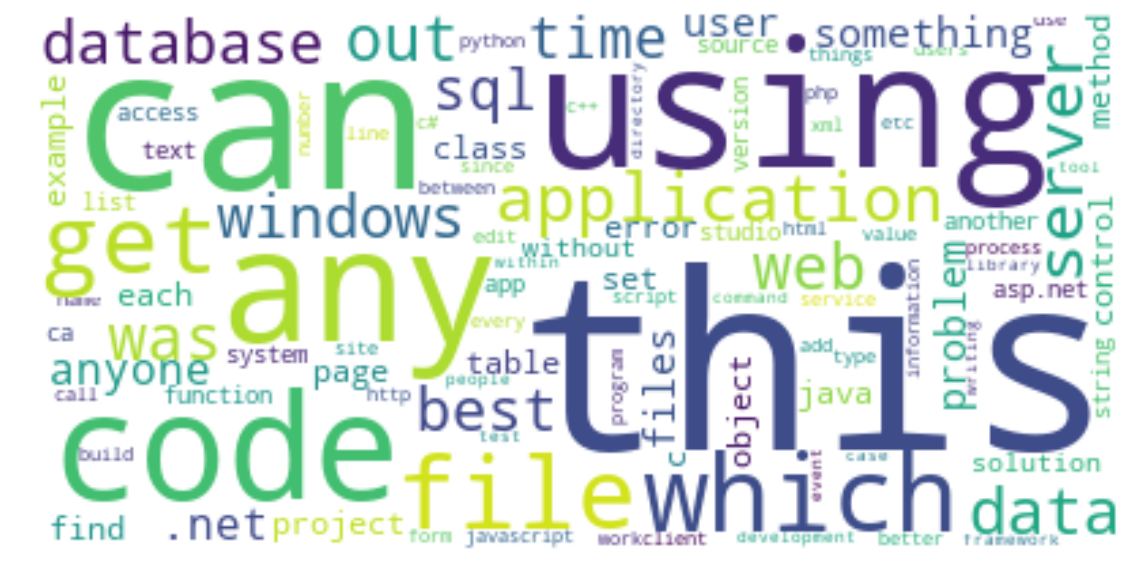

In [67]:
import p6_util_plot
import p6_util
dict_body_train = ser_sof_train.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='split')
p6_util_plot.display_word_cloud(freq_body_train)

<Figure size 720x720 with 0 Axes>

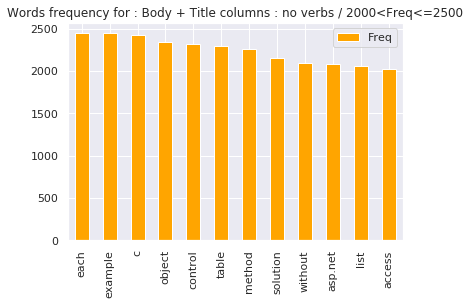

In [68]:
#from wordcloud import WordCloud, STOPWORDS 
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2000<Freq<=2500")

<Figure size 720x720 with 0 Axes>

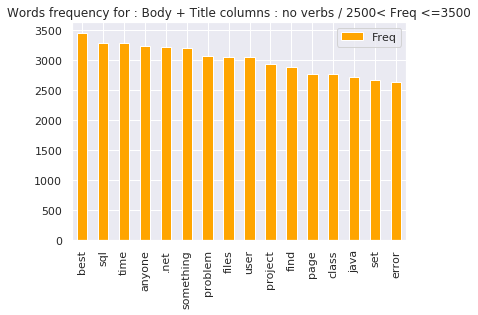

In [69]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2500< Freq <=3500")

<Figure size 720x720 with 0 Axes>

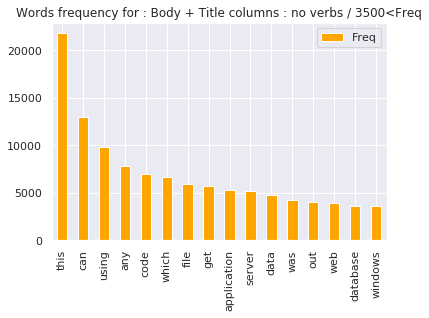

In [70]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="3500<Freq")

### <font color='blus'>3.2.2 Title analysis</font>

**<font color='blue'>Loading SOF TAGs as a referenced list</font>**

In [73]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

(50000, 2)


**<font color='blue'>Loading Title from Posts<font>**

In [74]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
ser_sof_title=pd.read_csv(file_name)['Title']
ser_sof_title.shape

(24604,)

In [75]:
ser_sof_title.tolist()[0]
dict_id_sentence = {key:value for key,value in zip(range(0,len(ser_sof_title.tolist())),ser_sof_title.tolist())}

In [76]:
import p6_util
dict_id_tokenized = p6_util.corpus_tokenization(dict_id_sentence, token_mode='nltk')

In [77]:
for key, list_tokenized in dict_id_tokenized.items():
    if 'd3.js' in list_tokenized :
        print('*** FOUND!')
        break

**<font color='blue'>Titles frequencies processing and plot</font>**

In [80]:
import p5_util
file_name='./data/ser_sof_train_title.dump'
ser_sof_train_title = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/ser_sof_train_title.dump


In [81]:
import p6_util

df_word_count = p6_util.ser_corpus_2_df_word_count(ser_sof_train_title, token_mode='nltk')

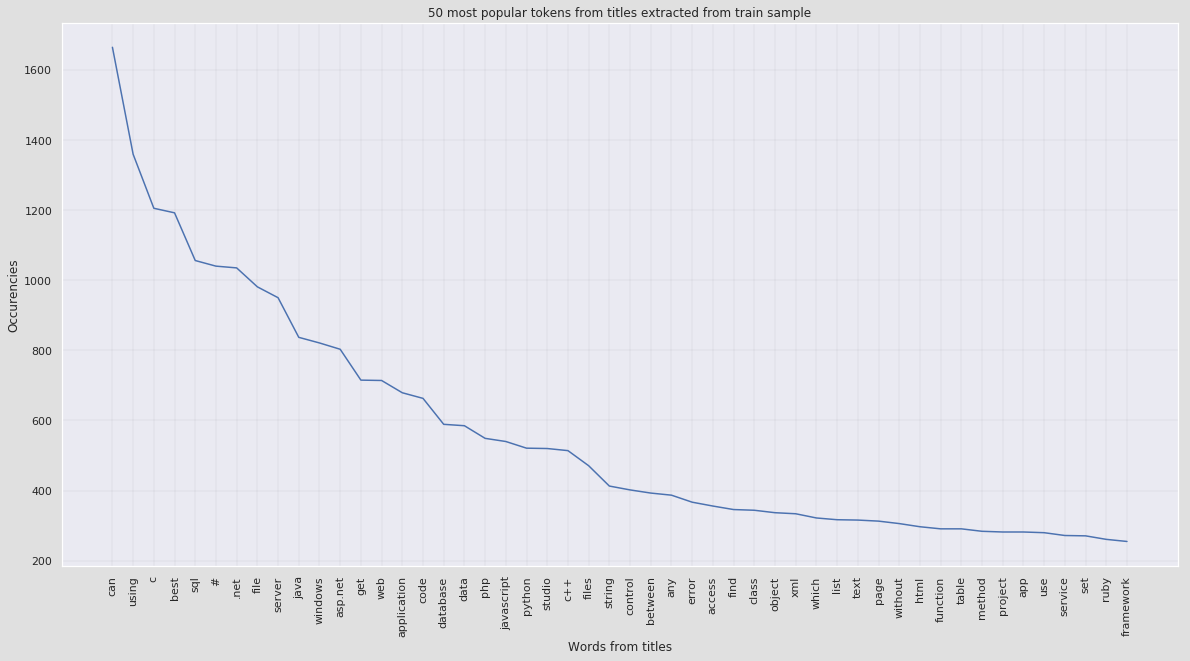

In [82]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular tokens from titles extracted from train sample"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count,item_count, title\
                                     ,p_y_title="Occurencies", p_x_title="Words from titles")

**Statistics of Titles tokens versus SOF TAGs**

In [83]:
intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG found in titles : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of ref. TAG in titles = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

Percent of TAG found in titles : 9.43%
Distribution of ref. TAG in titles = 42.98%


In [ ]:
import numpy as np

dep =df_word_count.Count.values

import matplotlib.pyplot as plt

lorenz = np.cumsum(np.sort(df_word_count.Count)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
plt.show()

# Pour l'indice de GINI
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

### <font color='blus'>3.2.3. Assigned TAG analysis from train sample</font>

**Loading SOF TAGs as a referenced list**

In [98]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist()

(50000, 2)


**Loading TAGs from Posts**

In [99]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
ser_train_tags=pd.read_csv(file_name).Tags.copy()
ser_train_tags.shape

(24604,)

**Assigned TAG are tokenized**

In [100]:
import p6_util

ser_train_tags = ser_train_tags.apply(p6_util.clean_marker_text, leading_marker='<'\
    , trailing_marker='>')

In [101]:
ser_train_tags.iloc[0]

['c#', 'floating-point', 'type-conversion', 'double', 'decimal']

**MAX number of TAG in train dataset**

In [102]:
max_tag_a = 0
avg_tag_a=0.0
for index in range(0,ser_train_tags.shape[0]):
    tag_list = ser_train_tags[index]
    #print(type(tag_list))
    avg_tag_a += len(tag_list)
    max_tag_a = max(max_tag_a,len(tag_list))
avg_tag_a /=ser_train_tags.shape[0]
print("Max number of TAG per POST : "+str(max_tag_a))
print("Average number of TAG per POST : {0:1.2F}".format(avg_tag_a))


Max number of TAG per POST : 6
Average number of TAG per POST : 2.91


In [103]:
ser_train_tags = ser_train_tags.apply(lambda x:" ".join(x))

In [104]:
import p6_util

df_word_count = p6_util.ser_corpus_2_df_word_count(ser_train_tags, token_mode='split')

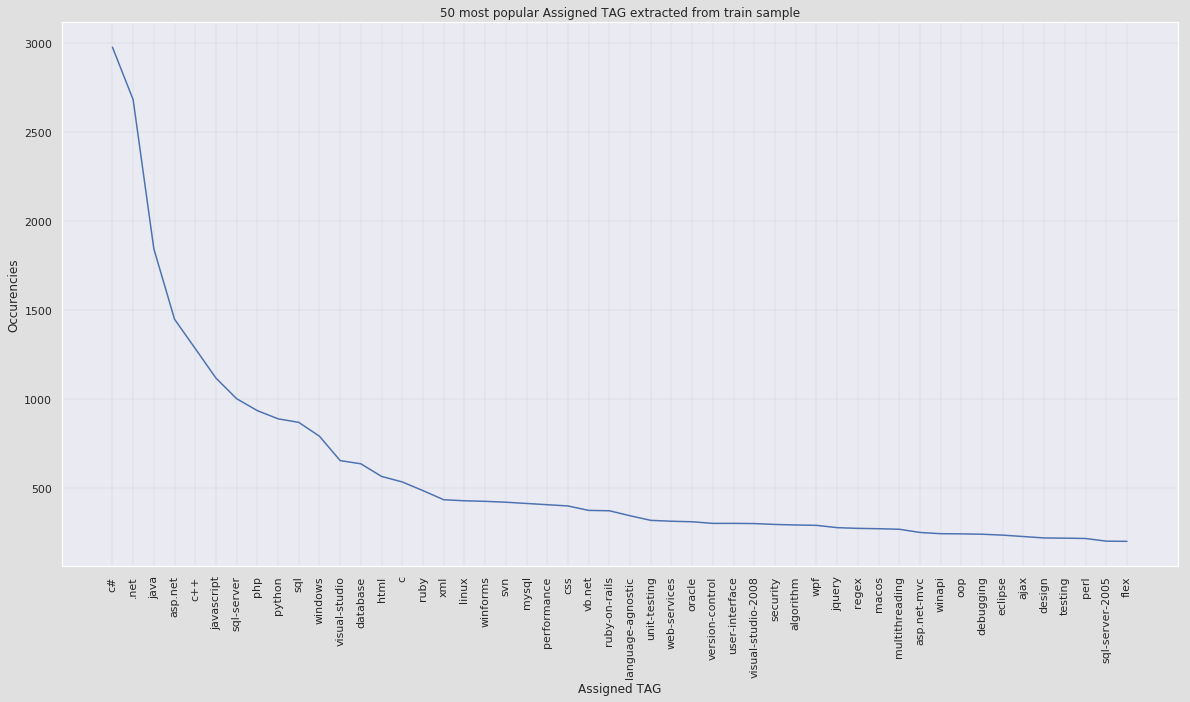

In [105]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular Assigned TAG extracted from train sample"
p6_util_plot.ser_item_occurency_plot(df_word_count.Word,df_word_count.Count,item_count, title\
                                     ,p_y_title="Occurencies", p_x_title="Assigned TAG")

In [106]:
intersection_count = len(set(df_sof_tags.TagName.tolist()).intersection(df_word_count.Word.tolist()))
reftags_count = len(df_sof_tags.TagName.tolist())
print("Percent of TAG_A found in TAG_R : {0:1.2F}%".format(100*intersection_count/reftags_count))
print("Distribution of TAG_R in TAG_A = {0:1.2F}%".format(100*intersection_count/len(df_word_count.Word.tolist())))

Percent of TAG_A found in TAG_R : 12.02%
Distribution of TAG_R in TAG_A = 93.38%
